In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import torch
from torch import nn
import torchvision.transforms as transforms
from tqdm import tqdm
from utils.loaders_viscosity import create_datasets, Dataset_3DCNN
from models.viscosity_models import CNNLayers, CNN3D
from utils.helper_fun import conv3D_output_size
from models.feedforward import LinLayers
from utils.datastruct import CNNData, LinData, NetData
from models.inference import get_inference, combine_train_and_val

C:\Users\biplabd\Anaconda3\envs\pyg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataloaders

In [2]:
base_path = r'D:\All_files\pys\AI_algos\Mikes_Work\viscosity-video-classification\viscosity_reg_modeling'
train_dl, test_dl, val_dl = create_datasets(path = os.path.join(base_path,'new_honey_164'), # absolute path
                    validation_split = 0.2,
                    test_split = 0.2,
                    batch_size = 5,
                    transform = transforms.Compose([transforms.Resize([256, 342]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]),
                    random_seed = 112, # same seed as training
                    shuffle = True,
                    selected_frames = np.arange(2,62,2))

length test set  33


## Model

In [3]:
# CNN3D Layer's architecture
cnndata = CNNData(in_dim = 1,
                  n_f =[32,48],
                  kernel_size=[(5,5,5), (3,3,3)],
                  activations=[nn.ReLU(),nn.ReLU()],
                  bns = [True, True],
                  dropouts = [0, 0],
                  paddings = [(0,0,0),(0,0,0)],
                  strides = [(2,2,2),(2,2,2)])

# Feedforward layer's architecture
lindata = LinData(in_dim = conv3D_output_size(cnndata, [30, 256, 342]),
                  hidden_layers= [256,256,1],
                  activations=[nn.ReLU(),nn.ReLU(),None],
                  bns=[False,False,False],
                  dropouts =[0.2, 0, 0])

# combined architecture
args = NetData(cnndata, lindata)

# weight file
weight_file = 'cnn3d_epoch_300.pt'
   
# CNN3D model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn3d = CNN3D(args).to(device)
cnn3d.load_state_dict(torch.load(os.path.join(base_path,'weights',weight_file)))
cnn3d.eval()
print(cnn3d)

CNN3D(
  (cnn3d): CNNLayers(
    (layers): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2))
        (1): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (lin): LinLayers(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1499904, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)


## Inference

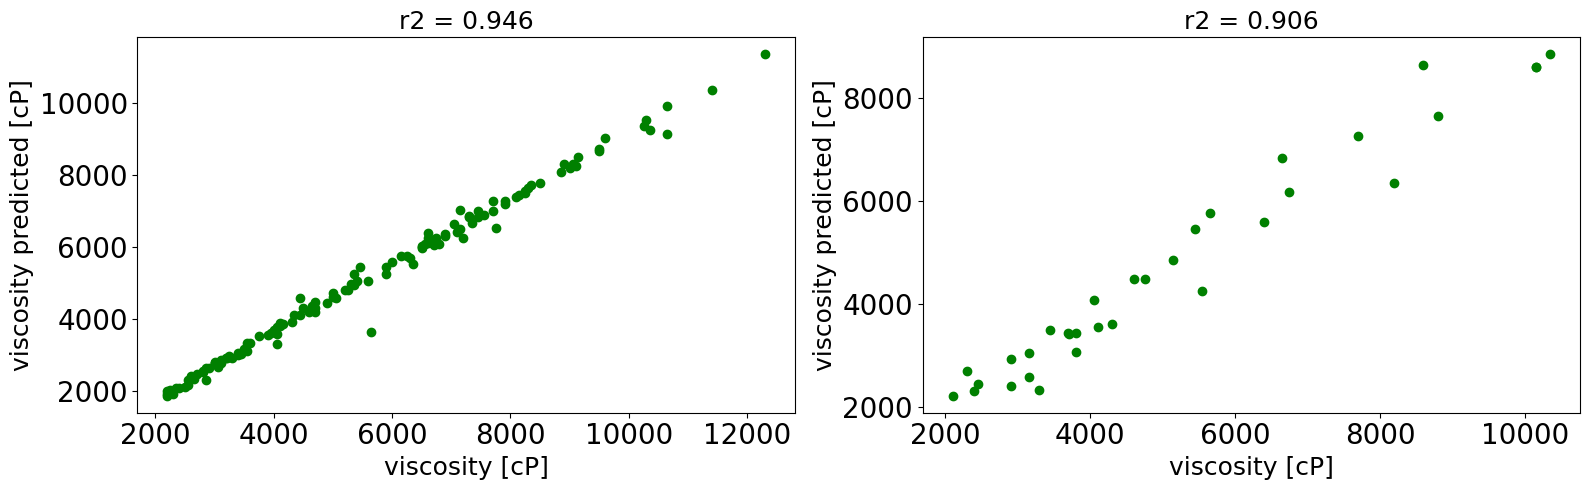

In [10]:
# training results
(df_train, r2_train) = get_inference(model = cnn3d, data_loader= train_dl, device = device)

# validation results
(df_val, r2_val) = get_inference(model = cnn3d, data_loader= val_dl, device = device)

# test results
(df_test, r2_test) = get_inference(model = cnn3d, data_loader= test_dl, device = device)


# plotting
(df_train, r2_train)=combine_train_and_val(df_train,df_val)
dfs = [df_train,df_test]
r2s = [r2_train,r2_test]

fig, ax = plt.subplots(1,len(r2s), figsize = (16,5))

for idx, (df,r2) in enumerate(zip(dfs,r2s)):
    ax[idx].plot(df['y'],df['y_h'],'go')
    ax[idx].set_xlabel('viscosity [cP]',fontsize = 18)
    ax[idx].set_ylabel('viscosity predicted [cP]',fontsize = 18)
    ax[idx].set_title('r2 = '+str(round(r2,3)),fontsize = 18)
    ax[idx].xaxis.set_tick_params(labelsize=20)
    ax[idx].yaxis.set_tick_params(labelsize=20)

fig.tight_layout()

plt.savefig('viscosity_pred.png',bbox_inches = 'tight')